In [1]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import Bio.PDB as pdb
import warnings
from Bio.PDB.QCPSuperimposer import QCPSuperimposer
from lattice import *
from scipy.spatial import distance_matrix
warnings.filterwarnings("ignore", category=RuntimeWarning) 

# Constants

In [2]:
CA_CA_DIST = 3.83
count = 4

# **Functions**

## **Basic**

In [3]:
def center_to_zero(points):
    return points - points.mean(axis = 0)

In [4]:
def angle_diff_rads(ang1, ang2):
    diff = np.abs(ang1 - ang2)
    diff = np.minimum(diff, 2*np.pi - diff)
    
    return diff

## **Metrics**

In [5]:
def get_rms(grp1, grp2):
    imposer = QCPSuperimposer()
    imposer.set(center_to_zero(grp1), 
                center_to_zero(grp2))
    imposer.run()
    return imposer.rms

In [6]:
def norm_direction(direction):
    step = np.linalg.norm(direction[1] - direction[0])
    return center_to_zero(direction) / step * CA_CA_DIST

# 1. Protein parsing

In [7]:
parser = pdb.PDBParser()
chain = parser.get_structure("s", "pdb2rqm.ent")[0].child_list[0].child_list
N = len(chain)

In [8]:
alphas = [pdb.calc_dihedral(chain[i - 1]["CA"].get_vector(), 
                            chain[i]["CA"].get_vector(), 
                            chain[i + 1]["CA"].get_vector(), 
                            chain[i + 2]["CA"].get_vector())
          for i in range(1, N - 2)]

In [9]:
ca_coords = np.array([res["CA"].coord for res in chain])
cb_coords = np.array([res["CB" if res.has_id("CB") else "CA"].coord for res in chain])
protein_distance = distance_matrix(ca_coords, ca_coords)

In [10]:
cur_lattice = CubicLattice()
basis = np.array(cur_lattice.vectors)

In [11]:
unified_ca_coords = center_to_zero(ca_coords) / CA_CA_DIST * np.linalg.norm(basis[0])

# 2. Алгоритм, основанный на минимизации разницы двугранных углов

## Assign first four $C_\alpha$:

In [12]:
combs = np.array(np.meshgrid(*[np.arange(len(cur_lattice.vectors))] * 3)).reshape((3,-1)).T

In [13]:
def make_points_from_comb(comb):
    coords = [lattice_points[-1] + np.sum([cur_lattice.vectors[nv] 
                                           for nv in comb[:i+1]], axis=0) 
              for i in range(len(comb))]
    if len(set([tuple(p) for p in coords])) != 3:
        return None
    return coords

In [14]:
lattice_points = np.zeros((1,3))

best_comb_ind, best_rms = -1, 1e3
drmsd = 1e3
cur_rms = 1e3

for k, comb in enumerate(combs):
    coords = make_points_from_comb(comb)
    if coords is None:
        continue
        
    cur_rms = get_rms(np.vstack(([lattice_points[-1]], 
                                 coords)),  
                      unified_ca_coords[:4])
    if cur_rms < best_rms:
        best_rms = cur_rms
        best_comb_ind = k

In [15]:
lattice_points = np.vstack((lattice_points, 
                            make_points_from_comb(combs[best_comb_ind])))

Посчитаем матрицу поворота:

In [16]:
imposer = QCPSuperimposer()
_, M, _ = imposer._align(center_to_zero(unified_ca_coords[:count]), 
                         center_to_zero(lattice_points[:count]))

In [17]:
M

array([[ 0.90705248, -0.31500868, -0.27933015],
       [-0.40943038, -0.81456913, -0.41090619],
       [-0.0980947 ,  0.48707972, -0.86783107]])

Повернем все $C_\alpha$ с помощью этой матрицы:

In [18]:
unified_ca_coords = (M @ unified_ca_coords.T).T

Переместим $C_\alpha$ так, чтобы центр первых трех атомов совпадал с центром первых трех выбранных точек решетки:

In [19]:
unified_ca_coords = unified_ca_coords + lattice_points[:count].mean(axis=0)

## Assign all remaining $C_\alpha$:

Выставим оставшиеся $C_\alpha$. Будем считать расстояние от атома, выставленного в решетке, до настоящих координат атома:

In [20]:
atom_offsets = np.linalg.norm(lattice_points[:4] - unified_ca_coords[:4], 
                              axis=1)
dihedral_offsets = np.empty(0)
atom_offsets, dihedral_offsets

(array([14.77531574, 14.64381454, 14.9311473 , 14.50824511]),
 array([], dtype=float64))

In [21]:
for i, at_coord in enumerate(unified_ca_coords[4:]):
    
    orig_bond_v = unified_ca_coords[4 + i] - unified_ca_coords[4 + i - 1]
    orig_bond_dihedral = alphas[i + 1]
    best_dist, best_dihedral, best_j = 1e3, np.nan, np.nan
    best_diff = np.inf
    loss = 1e3
    drmsd = 1e3
    
    for j, v in enumerate(cur_lattice.vectors):
        
        if (lattice_points[-1] + v).tolist() in lattice_points.tolist():
            continue
        
        if np.all(v == lattice_points[-1] - lattice_points[-2]):
            continue
        
        j_dist = np.linalg.norm(orig_bond_v - v)
        j_dihedral = pdb.calc_dihedral(*[pdb.Vector(*node) for node in
                                         np.vstack((lattice_points[-3:], 
                                                    lattice_points[-1] + v))])
        angle_diff = angle_diff_rads(j_dihedral, orig_bond_dihedral)

        if angle_diff_rads(j_dihedral, 
                           orig_bond_dihedral) < best_diff:
            best_dist, best_dihedral, best_j = j_dist, j_dihedral, j
            best_diff = angle_diff_rads(j_dihedral, 
                           orig_bond_dihedral)

    atom_offsets = np.append(atom_offsets, best_dist)
    dihedral_offsets = np.append(dihedral_offsets, angle_diff_rads(best_dihedral, orig_bond_dihedral))
    lattice_points = np.vstack((lattice_points, [lattice_points[-1] + cur_lattice.vectors[best_j]]))
    count += 1


# Отображение

In [33]:
%matplotlib notebook

<IPython.core.display.Javascript object>


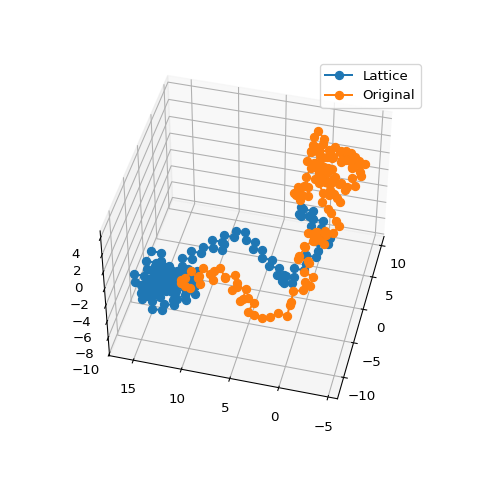

In [34]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(projection="3d")

ax.plot(*lattice_points.T, marker="o", label="Lattice")
ax.plot(*unified_ca_coords.T, marker="o", label="Original")

plt.legend()

plt.show()

In [24]:
print("Разница расстояний концов связей:\n", atom_offsets)

Разница расстояний концов связей:
 [14.77531574 14.64381454 14.9311473  14.50824511  0.28377766  0.93754095
  0.9622397   0.32845685  0.36052454  1.05953482  0.91077288  0.37058375
  1.47530589  1.23267442  1.79363938  0.77692316  1.66187407  1.69661045
  0.52106829  1.94380334  1.97125502  1.02253628  1.70319735  1.82527633
  1.82033744  0.82440762  1.80802798  1.8497839   1.53977724  1.80227258
  1.4858077   1.45227753  0.48747542  1.48433107  0.90451346  1.5601016
  1.23944593  1.54884051  1.36599739  1.68689839  1.02320407  1.25487287
  0.60130038  1.67825476  0.94210727  1.8720989   1.85439537  1.8181866
  0.80548998  1.88079581  0.84266772  1.94093078  1.9889681   0.30948877
  1.84861436  1.75553956  1.00871738  1.72696457  1.90412718  0.62363151
  1.90428095  0.66360747  1.95193003  0.71289769  1.73925822  0.6177061
  1.78115183  0.78895871  1.56778464  1.03424573  1.18853077  1.66873239
  1.14336944  1.77012649  0.85222521  1.71023832  1.40636744  1.4868688
  0.42951909  1.0556

In [25]:
print("Разница значений двугранных углов (в градусах):\n", dihedral_offsets / np.pi * 180)

Разница значений двугранных углов (в градусах):
 [ 12.05836369  30.88114379  39.74348959  40.69590548  33.79016062
  48.70465119  28.5257759   41.56194835  40.58487587  38.02481694
  44.8459989   49.2904228   13.03538768  39.03680339  43.03835742
  40.97707992  35.37077429  41.43171355  43.92062353  39.00652913
  40.05682322  39.75318566   7.02005797  10.72875834  24.09585186
  41.8336759   28.30913629  44.16762038  16.51529092   1.15520023
  26.18377307  24.58528817   0.22652693   8.07691374  26.79213055
  11.9053733    1.14409431  22.62510694  26.3460115   28.28792434
  11.13807802  25.080851    39.67514303  29.99591105  36.1542973
  41.16601347  11.38076607   8.31779285  33.86501591  42.16376176
  42.6494049   44.14503458   4.33723873  13.09173298   4.88830365
   6.27787857   0.67698978  10.41643636  44.01464573   2.853835
  39.53286837  40.9752178    9.39852326  17.40355502  19.34667789
  22.56644568  16.22309555  16.24708588  28.64685696   9.80977561
  13.20425796   8.73418482  35

In [26]:
med = np.median(dihedral_offsets / np.pi * 180)
print(med)

29.995911053374268


In [27]:
%matplotlib inline

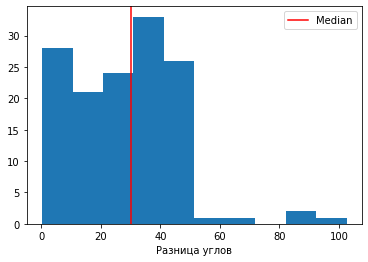

In [28]:
plt.hist(dihedral_offsets / np.pi * 180)
plt.axvline(x=med, color='r', label='Median')
plt.xlabel('Разница углов')
plt.legend()

In [29]:
lattice_distance = distance_matrix(norm_direction(center_to_zero(lattice_points)), 
                                                  norm_direction(center_to_zero(lattice_points)))

## Матрицы расстояний

In [30]:
%matplotlib inline

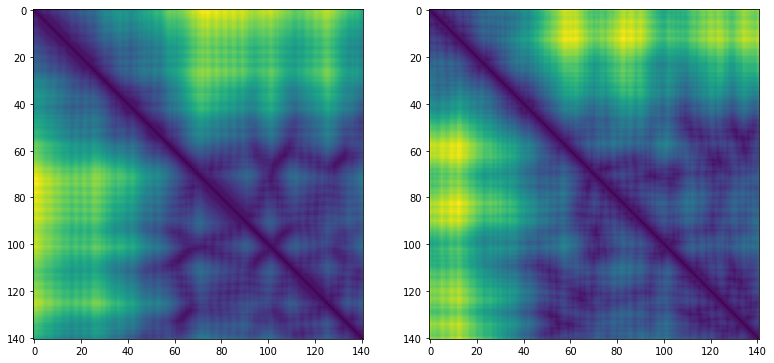

In [31]:
_, axs = plt.subplots(nrows=1, ncols=2, figsize = (13, 13))
axs[0].imshow(protein_distance)
axs[1].imshow(lattice_distance)
plt.show()

## Матрицы контактов

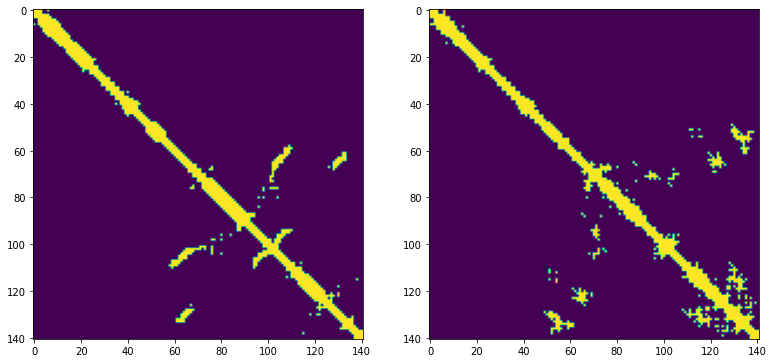

In [32]:
_, axs = plt.subplots(nrows=1,ncols=2,figsize=(13,13))

axs[0].imshow(protein_distance < 8)
axs[1].imshow(lattice_distance < 8)

plt.show()